# LIBRARIES SET UP

In [1]:
'''In case you encounter the error: 
"CRSError: Invalid projection: EPSG:4326: (Internal Proj Error: proj_create: no database context specified)"
Uncomment and run the following code; then, continue.'''
import os
import pyproj

proj_path = r"C:\Users\Administrador\anaconda3\envs\cmcc_env\Library\share\proj"

# Force pyproj to use PROJ db
os.environ["PROJ_LIB"] = proj_path
pyproj.datadir.set_data_dir(proj_path)

print("PROJ path set in:", pyproj.datadir.get_data_dir())


PROJ path set in: C:\Users\Administrador\anaconda3\envs\cmcc_env\Library\share\proj


C:\Users\Administrador\anaconda3\envs\cmcc_env\lib\site-packages\pyproj\network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)


In [2]:
import os
import geopandas as gpd
import pandas as pd
import numpy as np
import unicodedata, re
from shapely.geometry import box, Point

# For Sentinel-5P access

import ee
import geemap.core as geemap

ee.Authenticate()
ee.Initialize(project='ee-saudisis') # project='ProjectID'Change to your ProjectID

import geemap
import xarray as xr # to read .nc

from datetime import timedelta
from datetime import datetime
import time
from tqdm import tqdm  # for progress bar visualization

import requests
from pathlib import Path

from scipy.spatial import distance_matrix # for grid creation

# Buttons
import ipywidgets as widgets
from IPython.display import display, clear_output

# APIs
import requests
from sodapy import Socrata
from ddsapi import Client  # For CMCC DDS
import cdsapi

import glob


# CONFIGURATION SET UP

To initialize the project, user must:
### TIME WINDOW INPUT ->
                        Use to know the approximate time the satellite passess over you AOI. Use as current the hour range the satellite passes, and the rest, as previous.
You can use the Copernicus browser: https://browser.dataspace.copernicus.eu/?zoom=5&lat=50.16282&lng=20.78613&demSource3D=%22MAPZEN%22&cloudCoverage=30&dateMode=SINGLE. 
If you click on “Find products for current view”, and then click on “product info”, then you can see the sensing time in the pop up.

### BOUNDING BOX INPUT ->
                        Use to limit your Area Of Interest
Suggested: 

| Province             | Min Lon | Min Lat | Max Lon | Max Lat |
| -------------------- | ------- | ------- | ------- | ------- |
| **Milan (Milano)**   | 8.9     | 45.3    | 9.6     | 45.7    |
| **Monza e Brianza**  | 9.1     | 45.55   | 9.45    | 45.75   |
| **Varese**           | 8.55    | 45.65   | 8.95    | 46.15   |
| **Como**             | 8.85    | 45.70   | 9.30    | 46.20   |
| **Lecco**            | 9.25    | 45.75   | 9.60    | 46.15   |
| **Bergamo**          | 9.45    | 45.55   | 10.15   | 46.10   |
| **Brescia**          | 9.85    | 45.25   | 10.70   | 46.25   |
| **Pavia**            | 8.70    | 44.80   | 9.35    | 45.25   |
| **Lodi**             | 9.25    | 45.15   | 9.65    | 45.45   |
| **Cremona**          | 9.55    | 45.00   | 10.25   | 45.45   |
| **Mantova (Mantua)** | 10.30   | 44.90   | 11.00   | 45.35   |
| **Sondrio**          | 9.25    | 46.05   | 10.40   | 46.65   |


In [6]:
#  Initialize empty cfg 
cfg = {}

#  Widgets for BOUNDING BOX 
lon_min = widgets.FloatText(value=8.9, description='Min Lon:')
lat_min = widgets.FloatText(value=45.3, description='Min Lat:')
lon_max = widgets.FloatText(value=9.6, description='Max Lon:')
lat_max = widgets.FloatText(value=45.7, description='Max Lat:')

#  Widgets for TIME WINDOWS 
prev_start = widgets.Text(value='15:01', description='Prev start:')
prev_end = widgets.Text(value='11:59', description='Prev end:')
curr_start = widgets.Text(value='12:00', description='Curr start:')
curr_end = widgets.Text(value='15:00', description='Curr end:')

# Button to apply configuration
button = widgets.Button(description="Generate cfg", button_style='success')
output = widgets.Output()

def on_button_clicked(b):
    global cfg
    with output:
        clear_output()
        cfg = {
            "bbox": [lon_min.value, lat_min.value, lon_max.value, lat_max.value],
            "crs_grid": "EPSG:32632",
            "crs_gee": "EPSG:4326",
            "sentinel_scale_km": 5.5,
            "arpa_resolution_deg": 0.005,
            "start_date": None,
            "end_date": None,
            "time_windows": {
                "prev": (prev_start.value, prev_end.value),
                "curr": (curr_start.value, curr_end.value)
            }
        }

        # Construct AOI GeoDataFrame
        minx, miny, maxx, maxy = cfg["bbox"]
        aoi = gpd.GeoDataFrame(
            {"id": [1]},
            geometry=[box(minx, miny, maxx, maxy)],
            crs=cfg["crs_gee"]
        )
        aoi_utm = aoi.to_crs(cfg["crs_grid"])
        aoi_gee = ee.Geometry.Rectangle([minx, miny, maxx, maxy])

        cfg["aoi"] = aoi
        cfg["aoi_utm"] = aoi_utm
        cfg["aoi_gee"] = aoi_gee

        print("Configuration saved to variable `cfg`. Continue")
        #print("Current cfg")
        #print(cfg)

button.on_click(on_button_clicked)

# Display interface
print("Adjust bounding box and time windows, then click 'Generate cfg':")
bbox_box = widgets.VBox([lon_min, lat_min, lon_max, lat_max])
time_box = widgets.VBox([prev_start, prev_end, curr_start, curr_end])
ui = widgets.HBox([bbox_box, time_box])

display(ui, button, output)


Adjust bounding box and time windows, then click 'Generate cfg':


Button(button_style='success', description='Generate cfg', style=ButtonStyle())

Output()

In [7]:
start_date_widget = widgets.DatePicker(description="Start Date:")
end_date_widget = widgets.DatePicker(description="End Date:")
save_button = widgets.Button(description="Save Dates", button_style="success")
output_range = widgets.Output()

display(start_date_widget, end_date_widget, save_button, output_range)

def save_dates(b):
    with output_range:
        output_range.clear_output()

        # Save in global variables and cfg
        global start_date, end_date
        start_date = pd.to_datetime(start_date_widget.value)
        end_date = pd.to_datetime(end_date_widget.value)

        cfg["start_date"] = start_date
        cfg["end_date"] = end_date

        print(f" Dates have been saved:")
        print(f" Start: {start_date.date()}")
        print(f" End: {end_date.date()}")
        print(f" Please, continue")
        
save_button.on_click(save_dates)

DatePicker(value=None, description='Start Date:', step=1)

DatePicker(value=None, description='End Date:', step=1)

Button(button_style='success', description='Save Dates', style=ButtonStyle())

Output()

In [8]:
# Date Range Definition
if cfg["start_date"] is not None and cfg["end_date"] is not None:
    dates = pd.date_range(cfg["start_date"], cfg["end_date"], freq="D")
    #print("Dates:", dates[:10], "...")
else:
    print("Date Range not yet defined.")

dates = pd.date_range(cfg["start_date"], cfg["end_date"], freq="D")
print("Process through", [d.date() for d in dates])

Process through [datetime.date(2025, 6, 1), datetime.date(2025, 6, 2), datetime.date(2025, 6, 3)]


# ARPA

##### In order to download ARPA data, you must have an account at: https://www.dati.lombardia.it/login 
##### Once you register, you will have access to an App Token that can be found here: https://www.dati.lombardia.it/profile/edit/developer_settings
##### Please copy your token for the app_token variable.
##### *Note: ARPAs' creation date was novemeber 20, 2017. Data prior to that date is not available. 

### ARPA Lombardia Data Download and Analysis

In [9]:
# 1. Configuration
app_token = "vgiEMaAWkrTroWwi42G71LlIS"
headers = {"X-App-Token": app_token}

# Endpoints (main + fallback)
data_url = "https://www.dati.lombardia.it/resource/nicp-bhqi.json"   # Main endpoint
backup_url = "https://www.dati.lombardia.it/resource/g2hp-ar79.json"  # Fallback endpoint

# Metadata URL
meta_url = "https://www.dati.lombardia.it/resource/ib47-atvt.csv?$limit=50000"

# 2. Metadata Loading
meta = (
    pd.read_csv(meta_url)
    .dropna(subset=["idsensore", "nometiposensore", "lat", "lng", "provincia"])
    .assign(
        idsensore=lambda df: df["idsensore"].astype(int),
        provincia=lambda df: df["provincia"].str.upper()
    )
)
provinces = sorted(meta["provincia"].unique())
pollutants = sorted(meta["nometiposensore"].unique())

province = widgets.Dropdown(options=provinces, description="Province:")
pollutant = widgets.Dropdown(options=pollutants, description="Pollutant:")
display(province, pollutant)

# 3. Download Function
def download_data(province, pollutant):
    meta_f = meta[
        (meta["provincia"] == province.upper()) &
        (meta["nometiposensore"] == pollutant)
    ]
    if meta_f.empty:
        print(f"No sensors for '{pollutant}' in '{province}'")
        return None
    print(f"\nSensors found in {province} for {pollutant}: {len(meta_f)}.")
    print(f"\nPlease wait until message of complete successful download appears, only then, click Analyze.")

    ids = meta_f["idsensore"].tolist()
    all_data = []

    if cfg["start_date"] is None or cfg["end_date"] is None:
        print("Please define start_date and end_date before downloading.")
        return None

    # Iterate through date range
    for date_analysis in pd.date_range(cfg["start_date"], cfg["end_date"], freq="D"):
        y, m, d = date_analysis.year, date_analysis.month, date_analysis.day
        print(f"\nDownloading data: {pollutant} ({province}) for {date_analysis.date()}")

        params = {
            "$select": "idsensore,data,valore",
            "$where": f"date_extract_y(data)={y} AND date_extract_m(data)={m} AND date_extract_d(data)={d}",
            "$limit": 50000
        }

        # Try both endpoints sequentially
        urls_to_try = [data_url, backup_url]

        data = pd.DataFrame()
        for url in urls_to_try:
            try:
                print(f"→ Trying source: {url.split('/')[-1]} ...")
                r = requests.get(url, headers=headers, params=params)
                r.raise_for_status()
                temp = pd.DataFrame(r.json())
                if not temp.empty:
                    data = temp
                    print(f"Data found in {url.split('/')[-1]} ({len(data)} records)")
                    break
                else:
                    print("No data in this source, trying next")
            except Exception as e:
                print(f"Error with {url.split('/')[-1]}: {e}")

        if data.empty:
            print("No information available for this date in any source.")
            continue

        # Convert types
        data["idsensore"] = pd.to_numeric(data["idsensore"], errors="coerce").astype("Int64")
        data["data"] = pd.to_datetime(data["data"], errors="coerce")
        data["valore"] = pd.to_numeric(data["valore"], errors="coerce")
        data = data[data["idsensore"].isin(ids)]

        # Merge ARPA with Metadata
        merged = data.merge(meta_f, on="idsensore", how="inner")
        merged = merged.rename(columns={"nometiposensore": "pollutant", "valore": "value"})
        merged = merged[["idsensore", "pollutant", "data", "value", "lat", "lng", "provincia"]]
        merged["date"] = date_analysis.date()

        all_data.append(merged)
        print(f"{len(merged)} records downloaded for {date_analysis.date()}")

    if all_data:
        merged_all = pd.concat(all_data, ignore_index=True)
        print(f"\nCombined {len(all_data)} days of data ({cfg['start_date'].date()} - {cfg['end_date'].date()})")
        return merged_all
    else:
        print("No data downloaded in the selected range.")
        return None

# 4. Data Analysis
def analyze_data(merged, pollutant, province):
    if merged is None or merged.empty:
        print("No data to analyze.")
        return None

    if cfg["start_date"] is None or cfg["end_date"] is None:
        print("Date range hasn't been defined.")
        return None

    all_summaries = []

    for date_analysis in pd.date_range(cfg["start_date"], cfg["end_date"], freq="D"):
        prev_date = date_analysis - pd.Timedelta(days=1)
        subset = merged[merged["data"].dt.date.isin([prev_date.date(), date_analysis.date()])].copy()

        if subset.empty:
            print(f"No data for {date_analysis.date()}")
            continue

        subset["hour"] = subset["data"].dt.hour

        def classify_period(row):
            date, hour = row["data"].date(), row["hour"]
            if date == date_analysis.date() and 12 <= hour < 15:
                return "current"
            elif (date == prev_date.date() and hour >= 15) or (date == date_analysis.date() and hour < 12):
                return "previous"
            else:
                return None

        subset["period"] = subset.apply(classify_period, axis=1)
        subset = subset.dropna(subset=["period"])

        # Mean Computation
        summary = (
            subset.groupby(["idsensore", "lat", "lng", "provincia", "period"])["value"]
            .mean()
            .reset_index()
            .pivot(index=["idsensore", "lat", "lng", "provincia"],
                   columns="period",
                   values="value")
            .reset_index()
            .rename(columns={"current": "curr_mean", "previous": "prev_mean"})
        )

        summary["pollutant"] = pollutant
        summary["date"] = date_analysis.date()
        all_summaries.append(summary)
        print(f"Date analyzed: {date_analysis.date()} — Province: {province} — Pollutant: {pollutant}")

    if all_summaries:
        summary_all = pd.concat(all_summaries, ignore_index=True)
        print(f"\nAnalysis completed for {len(all_summaries)} days ({cfg['start_date'].date()} → {cfg['end_date'].date()})")
        display(summary_all.head())
        return summary_all
    else:
        print("No summaries generated.")
        return None

# 5. Interface (Widgets)
button_download = widgets.Button(description="Download Data", button_style="success")
button_analyze = widgets.Button(description="Analyze", button_style="info")
output = widgets.Output()

state = {"merged": None, "province": None, "pollutant": None}

def on_download(b):
    with output:
        output.clear_output()
        state["province"] = province.value
        state["pollutant"] = pollutant.value

        merged = download_data(state["province"], state["pollutant"])
        state["merged"] = merged

        # Save filtered metadata
        state["meta_f"] = meta[
            (meta["provincia"].str.upper() == state["province"].upper()) &
            (meta["nometiposensore"] == state["pollutant"])
        ]

        if merged is not None and not merged.empty:
            print("\nData and metadata loaded successfully. Click Analyze to proceed")
        else:
            print("No data was downloaded. Retry.")

def on_analyze(b):
    with output:
        output.clear_output()
        gdf = analyze_data(state["merged"], state["pollutant"], state["province"])
        if gdf is not None:
            state["summary"] = gdf
            print("GeoDataFrame created successfully. You can continue")

button_download.on_click(on_download)
button_analyze.on_click(on_analyze)

print("\nFIRST: Choose the Province and Pollutant of Interest and click Download Data\n")
display(button_download, button_analyze, output)


Dropdown(description='Province:', options=('BG', 'BS', 'CO', 'CR', 'LC', 'LO', 'MB', 'MI', 'MN', 'NO', 'PV', '…

Dropdown(description='Pollutant:', options=('Ammoniaca', 'Arsenico', 'Benzene', 'Benzo(a)pirene', 'Biossido di…


FIRST: Choose the Province and Pollutant of Interest and click Download Data



Button(button_style='success', description='Download Data', style=ButtonStyle())

Button(button_style='info', description='Analyze', style=ButtonStyle())

Output()

###  ARPA Grid Generation

In [10]:
def build_grid(meta_f, pollutant):

    # Sensors GeoDataFrame
    sensors_gdf = gpd.GeoDataFrame(
        meta_f,
        geometry=gpd.points_from_xy(meta_f["lng"], meta_f["lat"]),
        crs="EPSG:4326"
    )

    # Compute Distance Matrix (degrees)
    coords = np.array(list(zip(sensors_gdf.geometry.x, sensors_gdf.geometry.y)))
    if len(coords) < 2:
        print("Cannot compute grid: only one sensor available.")
        return None

    dist_mat = distance_matrix(coords, coords)
    dist_mat[dist_mat == 0] = np.nan  # avoid zero distances

    min_dist_deg = np.nanmin(dist_mat)
    if np.isnan(min_dist_deg) or min_dist_deg == 0:
        print("Cannot compute grid: invalid or identical coordinates.")
        return None

    print(f"\nMinimum distance between sensors ({pollutant}): {min_dist_deg:.6f} degrees")

    # Grid Resolution 
    # Use 90% of minimum distance to make grid slightly denser than sensor spacing
    res = min_dist_deg * 0.9

    # Grid Creation within bounding box 
    minx, miny, maxx, maxy = sensors_gdf.total_bounds
    xs = np.arange(minx, maxx, res)
    ys = np.arange(miny, maxy, res)

    grid_points = [Point(x, y) for x in xs for y in ys]
    grid_gdf = gpd.GeoDataFrame(
        {"grid_id": range(len(grid_points))},
        geometry=grid_points,
        crs="EPSG:4326"
    )

    print(f"\nGrid generated for {pollutant}: {len(grid_gdf)} points — resolution ≈ {res:.6f}°")
    display(grid_gdf.head())

    return grid_gdf


meta_f = state["meta_f"]
pollutant_name = state["pollutant"]

print("\nSelected sensors for grid generation:")
display(meta_f[["idsensore", "nometiposensore", "lat", "lng"]])
print(f"Total sensors: {len(meta_f)}")

# Build grid
grid_gdf = build_grid(meta_f, pollutant_name)

# Save in state for later ERA5 interpolation
state["grid_gdf"] = grid_gdf



Selected sensors for grid generation:


,idsensore,nometiposensore,lat,lng
48,5797,Monossido di Carbonio,45.730837,9.125739
166,5801,Monossido di Carbonio,45.688657,9.180658
340,5802,Monossido di Carbonio,45.783899,8.966405
710,5798,Monossido di Carbonio,45.815042,9.066979
747,5799,Monossido di Carbonio,45.808574,9.221779
919,5800,Monossido di Carbonio,45.748045,9.042599


Total sensors: 6

Minimum distance between sensors (Monossido di Carbonio): 0.069247 degrees

Grid generated for Monossido di Carbonio: 15 points — resolution ≈ 0.062323°


,grid_id,geometry
0,0,POINT (8.9664 45.68866)
1,1,POINT (8.9664 45.75098)
2,2,POINT (8.9664 45.8133)
3,3,POINT (9.02873 45.68866)
4,4,POINT (9.02873 45.75098)


# ERA5

## ACCESS TO ERA5

##### Before accessing ERA5, please read and setup de CDSAPI.
##### You can follow the instructions from this webpage: https://cds.climate.copernicus.eu/how-to-api

### API fetch - ERA5 Download

In [11]:
# Clean previous downloads
for f in glob.glob("era5_data/*.nc"):
    os.remove(f)
print("Removed previous ERA5 files (if any). The folder is ready for new downloads.")

# Initialize CDS client
client = cdsapi.Client()
os.makedirs("era5_data", exist_ok=True)

start_date = pd.to_datetime(cfg["start_date"])
end_date = pd.to_datetime(cfg["end_date"])

if start_date > end_date:
    print("❌ Invalid date range: start_date is after end_date.")
else:
    bbox = [7, 44, 10, 48]
    area = [bbox[3], bbox[0], bbox[1], bbox[2]]

    variables = [
        "2m_temperature",
        "surface_net_solar_radiation",
        "surface_net_thermal_radiation",
        "surface_pressure",
        "total_precipitation",
        "10m_u_component_of_wind",
        "10m_v_component_of_wind",
        "boundary_layer_height"
    ]

    for var in variables:
        out_file = f"era5_data/{var}_{start_date.date()}_{end_date.date()}.nc"
        if os.path.exists(out_file):
            print(f"✅ {var} already exists — skipping download.")
            continue

        try:
            print(f"⬇️ Downloading {var} ({start_date.date()} → {end_date.date()})...")
            client.retrieve(
                "reanalysis-era5-single-levels",
                {
                    "product_type": "reanalysis",
                    "format": "netcdf",
                    "variable": [var],
                    "date": f"{start_date.date()}/{end_date.date()}",
                    "time": [f"{h:02d}:00" for h in range(24)],
                    "area": area
                },
                out_file
            )
            print(f"✅ Saved: {out_file}")

        except Exception as e:
            print(f"❌ Error downloading {var}: {e}")

    print("\n✅ All downloads completed. Files saved in /era5_data/")


Removed previous ERA5 files (if any). The folder is ready for new downloads.
⬇️ Downloading 2m_temperature (2025-06-01 → 2025-06-03)...


2025-11-11 18:41:59,740 INFO Request ID is 24cabfdc-61cb-44e9-9ca9-b30dd5179192
2025-11-11 18:41:59,840 INFO status has been updated to accepted
2025-11-11 18:42:13,536 INFO status has been updated to running
2025-11-11 18:42:21,169 INFO status has been updated to successful


b7fe7d95b2fcea413b57b077072f4589.nc:   0%|          | 0.00/54.5k [00:00<?, ?B/s]

2025-11-11 18:42:21,811 INFO Request ID is c98e612e-d8bf-4c8a-b274-082b95842244


✅ Saved: era5_data/2m_temperature_2025-06-01_2025-06-03.nc
⬇️ Downloading surface_net_solar_radiation (2025-06-01 → 2025-06-03)...


2025-11-11 18:42:21,863 INFO status has been updated to accepted
2025-11-11 18:42:30,366 INFO status has been updated to running
2025-11-11 18:42:43,269 INFO status has been updated to successful


f2c461d71d49e587983e7b5dc4518de6.nc:   0%|          | 0.00/46.8k [00:00<?, ?B/s]

✅ Saved: era5_data/surface_net_solar_radiation_2025-06-01_2025-06-03.nc
⬇️ Downloading surface_net_thermal_radiation (2025-06-01 → 2025-06-03)...


2025-11-11 18:42:44,496 INFO Request ID is 510cfc18-683e-4f0d-8bd0-4b6548bd1aaa
2025-11-11 18:42:44,600 INFO status has been updated to accepted
2025-11-11 18:42:58,418 INFO status has been updated to running
2025-11-11 18:43:17,882 INFO status has been updated to successful


2603f26ca1fbe39594cb573f1e724737.nc:   0%|          | 0.00/62.3k [00:00<?, ?B/s]

✅ Saved: era5_data/surface_net_thermal_radiation_2025-06-01_2025-06-03.nc
⬇️ Downloading surface_pressure (2025-06-01 → 2025-06-03)...


2025-11-11 18:43:18,907 INFO Request ID is b9634c43-76b8-401f-93b6-8a39ff20398e
2025-11-11 18:43:19,009 INFO status has been updated to accepted
2025-11-11 18:43:27,508 INFO status has been updated to running
2025-11-11 18:44:09,083 INFO status has been updated to successful


325a9460ee2c06066822d468fa4fd897.nc:   0%|          | 0.00/48.9k [00:00<?, ?B/s]

✅ Saved: era5_data/surface_pressure_2025-06-01_2025-06-03.nc
⬇️ Downloading total_precipitation (2025-06-01 → 2025-06-03)...


2025-11-11 18:44:10,312 INFO Request ID is 66064b4e-2f21-477b-b4d2-6f410d24570a
2025-11-11 18:44:10,410 INFO status has been updated to accepted
2025-11-11 18:44:24,547 INFO status has been updated to running
2025-11-11 18:44:43,800 INFO status has been updated to successful


8f8faa4c6e42eef67f8dac9efafadbae.nc:   0%|          | 0.00/48.1k [00:00<?, ?B/s]

✅ Saved: era5_data/total_precipitation_2025-06-01_2025-06-03.nc
⬇️ Downloading 10m_u_component_of_wind (2025-06-01 → 2025-06-03)...


2025-11-11 18:44:45,334 INFO Request ID is 89d2f75f-8333-42bc-a13a-d67f4825a9f6
2025-11-11 18:44:45,437 INFO status has been updated to accepted
2025-11-11 18:44:54,434 INFO status has been updated to running
2025-11-11 18:45:07,248 INFO status has been updated to successful


f2a3bf83e43105f4c200bdeac54f30c7.nc:   0%|          | 0.00/63.7k [00:00<?, ?B/s]

✅ Saved: era5_data/10m_u_component_of_wind_2025-06-01_2025-06-03.nc
⬇️ Downloading 10m_v_component_of_wind (2025-06-01 → 2025-06-03)...


2025-11-11 18:45:08,170 INFO Request ID is 31f532e4-5076-4ce4-ad02-63d4185dc0cb
2025-11-11 18:45:08,273 INFO status has been updated to accepted
2025-11-11 18:45:21,995 INFO status has been updated to running
2025-11-11 18:45:58,347 INFO status has been updated to successful


80d13231bde11c1125deaf65fca70c6b.nc:   0%|          | 0.00/63.6k [00:00<?, ?B/s]

✅ Saved: era5_data/10m_v_component_of_wind_2025-06-01_2025-06-03.nc
⬇️ Downloading boundary_layer_height (2025-06-01 → 2025-06-03)...


2025-11-11 18:46:00,395 INFO Request ID is 383e9047-8662-4d43-827b-b6eb24545797
2025-11-11 18:46:00,497 INFO status has been updated to accepted
2025-11-11 18:46:14,220 INFO status has been updated to running
2025-11-11 18:46:50,573 INFO status has been updated to successful


6e9f85c51f11abd2bc8c05d44df7e5cb.nc:   0%|          | 0.00/62.8k [00:00<?, ?B/s]

✅ Saved: era5_data/boundary_layer_height_2025-06-01_2025-06-03.nc

✅ All downloads completed. Files saved in /era5_data/


### One dataset with all variables:

In [12]:
# Merge all .nc files into one data set
folder = "era5_data"
files = sorted(glob.glob(os.path.join(folder, "*.nc")))
datasets = [xr.open_dataset(f) for f in files]
merged_xr = xr.merge(datasets)   # xarray copy if future need

# Convert to Dataframe
ds_merged = merged_xr.to_dataframe().reset_index()

print("Merged Dataset")
display(ds_merged.head())

Merged Dataset


,valid_time,latitude,longitude,number,expver,u10,v10,t2m,blh,ssr,str,sp,tp
0,2025-06-01,48.0,7.00,0,0001,0.977097,2.237000,290.674561,158.644012,3.599999e-12,-155913.125,95513.3125,0.000014
1,2025-06-01,48.0,7.25,0,0001,1.204636,2.331726,290.735107,138.144012,3.599999e-12,-157321.125,96657.3125,0.000000
2,2025-06-01,48.0,7.50,0,0001,0.482956,2.759460,291.260498,128.144012,3.599999e-12,-165993.125,98208.3125,0.000000
3,2025-06-01,48.0,7.75,0,0001,0.150925,2.892273,290.934326,113.269020,3.599999e-12,-165705.125,96739.3125,0.000000
4,2025-06-01,48.0,8.00,0,0001,-0.131302,2.854187,290.104248,100.644020,3.599999e-12,-159177.125,94099.3125,0.000000


### Units Conversion

In [13]:
# Units Conversion

# Temperature from [K to °C]
if "t2m" in ds_merged:
    ds_merged["t2m_c"] = ds_merged["t2m"] - 273.15

# Pressure from [Pa to hPa]
if "sp" in ds_merged:
    ds_merged["sp_hpa"] = ds_merged["sp"] / 100.0

# Surface Solar Radiation from [J to kJ]
if "ssr" in ds_merged:
    ds_merged["ssr_kJ"] = ds_merged["ssr"] / 1000.0

# Surface Thermal Radiation from [J to kJ]
if "str" in ds_merged:
    ds_merged["str_kJ"] = ds_merged["str"] / 1000.0

# Boundary Layer Height [m to km]
if "blh" in ds_merged:
    ds_merged["blh_km"] = ds_merged["blh"] / 1000.0

# Total windspeed computation [m/s] (using u10 and v10)
if all(v in ds_merged for v in ["u10", "v10"]):
    ds_merged["wind_speed"] = np.sqrt(ds_merged["u10"]**2 + ds_merged["v10"]**2)

#display(ds_merged.head(20))

### Grid Alignment for future interpolation

In [14]:
# Grid alignment

grid_wgs84 = grid_gdf.to_crs("EPSG:4326")
grid_wgs84["lat"] = grid_wgs84.geometry.y
grid_wgs84["lon"] = grid_wgs84.geometry.x

### ERA5 + ARPA variables interpolation process

In [15]:
# Interpolated variables to join with ARPA

# DataFrame to xarray Dataset
ds_xr = ds_merged.set_index(["valid_time", "latitude", "longitude"]).to_xarray()

vars_era5 = ["t2m_c", "sp_hpa", "wind_speed", "blh_km", "tp", "ssr_kJ", "str_kJ"]
results = []

for t in tqdm(ds_xr["valid_time"].values, desc="Interpolating ERA5 on ARPA grid"):
    ds_hour = ds_xr.sel(valid_time=t)

    # Bilinear interpolation on the grid
    interp = ds_hour[vars_era5].interp(
        latitude=("points", grid_wgs84["lat"]),
        longitude=("points", grid_wgs84["lon"])
    )

# To DataFrame
    interp_df = interp.to_dataframe().reset_index(drop=True)
    interp_df["valid_time"] = pd.to_datetime(t)

# Grid Coordinates 
    interp_df["grid_id"] = grid_wgs84["grid_id"]
    interp_df["lat"] = grid_wgs84["lat"]
    interp_df["lon"] = grid_wgs84["lon"]
    
    results.append(interp_df)

# Concatenate
era5_on_arpa = pd.concat(results, ignore_index=True)

print(era5_on_arpa.head())
print(f"\nConcatenated number of rows: {len(era5_on_arpa)}")

Interpolating ERA5 on ARPA grid: 100%|█████████████████████████████████████████████████| 72/72 [00:01<00:00, 66.40it/s]

       t2m_c      sp_hpa  wind_speed    blh_km   tp        ssr_kJ      str_kJ  \
0  19.708088  981.154402    1.558744  0.081141  0.0  3.599999e-15 -131.847693   
1  19.312857  976.073054    1.270106  0.066445  0.0  3.599999e-15 -136.411463   
2  18.947636  966.518983    1.138578  0.052997  0.0  3.599999e-15 -139.680797   
3  19.662837  979.987096    1.613072  0.084560  0.0  3.599999e-15 -130.641445   
4  19.210105  974.218526    1.320234  0.070433  0.0  3.599999e-15 -134.940290   

  valid_time   latitude  longitude  grid_id        lat       lon  
0 2025-06-01  45.688657   8.966405        0  45.688657  8.966405  
1 2025-06-01  45.750980   8.966405        1  45.750980  8.966405  
2 2025-06-01  45.813302   8.966405        2  45.813302  8.966405  
3 2025-06-01  45.688657   9.028727        3  45.688657  9.028727  
4 2025-06-01  45.750980   9.028727        4  45.750980  9.028727  

Concatenated number of rows: 1080


### ERA5 mean computation

In [16]:
# 1. ERA5 cleaning
era5_df = era5_on_arpa.drop(columns=["lat", "lon"], errors="ignore").copy()

# 2. Period time defined in cfg
def assign_period(df, date):
    curr_start = pd.to_datetime(f"{date} {cfg['time_windows']['curr'][0]}")
    curr_end   = pd.to_datetime(f"{date} {cfg['time_windows']['curr'][1]}")
    prev_start = pd.to_datetime(f"{(pd.to_datetime(date) - pd.Timedelta(days=1)).date()} {cfg['time_windows']['prev'][0]}")
    prev_end   = pd.to_datetime(f"{date} {cfg['time_windows']['prev'][1]}")

    def classify(ts):
        if curr_start <= ts <= curr_end:
            return "current"
        elif prev_start <= ts <= prev_end:
            return "previous"
        else:
            return None

    df["period"] = df["valid_time"].apply(classify)
    return df.dropna(subset=["period"])
    

for date_analysis in pd.date_range(cfg["start_date"], cfg["end_date"], freq="D"):
    print(f"\nProcessing ERA5 for {date_analysis.date()}")
    era5_df_day = assign_period(era5_df, date_analysis.date())

    era5_summary = (
        era5_df_day.groupby(["grid_id", "period"], as_index=False)
        .mean(numeric_only=True)
        .pivot(index="grid_id", columns="period")
        .reset_index()
    )
    print(f"\nGenerated rows for {date_analysis.date()}: {len(era5_summary)}")

# 3. Mean Computation
era5_summary = (
    era5_df.groupby(["grid_id", "period"], as_index=False)
    .mean(numeric_only=True)
    .pivot(index="grid_id", columns="period")
    .reset_index()
)

# Flatten MultiIndex
era5_summary.columns = [
    "_".join([str(c) for c in col if c not in ("", None)]).strip("_")
    if isinstance(col, tuple) else str(col)
    for col in era5_summary.columns
]

# 4. Removal of redundant coordinate columns
era5_summary = era5_summary.loc[:, ~era5_summary.columns.str.contains("lat|lon|latitude|longitude", case=False)]
era5_summary = era5_summary.drop(columns=["number_current", "number_previous"], errors="ignore")

# 5. Merge with grid coordinates
era5_summary = era5_summary.merge(
    grid_wgs84[["grid_id", "lat", "lon"]],
    on="grid_id",
    how="left"
)

# 6. Reordering for readability
ordered_cols = ["grid_id", "lat", "lon"] + sorted(
    [c for c in era5_summary.columns if any(x in c for x in ["_current", "_previous"])]
)
era5_summary = era5_summary[ordered_cols]

# Summary preview 
print(f"\nERA5 summary for {date_analysis.date()} ({pollutant.value}, {province.value})\n")
display(era5_summary.filter(regex="t2m|sp|wind|ssr|str|blh|tp|lat|lon").head())


Processing ERA5 for 2025-06-01

Generated rows for 2025-06-01: 15

Processing ERA5 for 2025-06-02

Generated rows for 2025-06-02: 15

Processing ERA5 for 2025-06-03

Generated rows for 2025-06-03: 15

ERA5 summary for 2025-06-03 (Monossido di Carbonio, CO)



,lat,lon,blh_km_current,blh_km_previous,sp_hpa_current,sp_hpa_previous,ssr_kJ_current,ssr_kJ_previous,str_kJ_current,str_kJ_previous,t2m_c_current,t2m_c_previous,tp_current,tp_previous,wind_speed_current,wind_speed_previous
0,45.688657,8.966405,0.687743,0.233491,978.894185,978.701934,1016.893783,257.944943,-124.133020,-78.169814,23.788778,19.692070,0.000201,0.000816,1.969796,1.014258
1,45.750980,8.966405,0.633122,0.212452,973.832078,973.601266,965.891086,245.311853,-115.326601,-73.106642,23.276338,19.261869,0.000248,0.000972,1.912963,0.978507
2,45.813302,8.966405,0.612937,0.199432,964.227750,963.951873,943.215496,242.620877,-109.584019,-70.149778,22.479125,18.600542,0.000437,0.001170,1.777429,0.952710
3,45.688657,9.028727,0.696238,0.236022,977.728970,977.520112,1055.198003,266.046557,-131.616804,-79.432203,23.823357,19.705056,0.000213,0.000739,1.884534,1.011830
4,45.750980,9.028727,0.640881,0.215588,971.979338,971.727060,1004.107627,253.047204,-122.584905,-73.219615,23.279596,19.228800,0.000266,0.000878,1.864579,0.982923


# ARPA + ERA5

In [17]:
# ERA5 summary to GeoDataFrame
summary = state["summary"]
era5_gdf = gpd.GeoDataFrame(
    era5_summary,
    geometry=gpd.points_from_xy(era5_summary["lon"], era5_summary["lat"]), 
    crs="EPSG:4326"
).to_crs("EPSG:32632")

# ARPA sensors (summary) to GeoDataFrame
summary_gdf = gpd.GeoDataFrame(
    summary,
    geometry=gpd.points_from_xy(summary["lng"], summary["lat"]),
    crs="EPSG:4326"
).to_crs("EPSG:32632")

# Search nearest ARPA sensor to ERA5 variable
era5_vars = [c for c in era5_summary.columns if "_current" in c or "_previous" in c]

for var in era5_vars:
    nearest_idx = era5_gdf.sindex.nearest(summary_gdf.geometry, return_all=False)[1]
    summary_gdf[var] = era5_gdf.iloc[nearest_idx][var].values

# New WGS84 
summary_gdf = summary_gdf.to_crs("EPSG:4326")

# ERA5 + ARPA
print(f"\nARPA sensors enriched with ERA5 variables for {state['pollutant']}"
      f"from {cfg['start_date'].date()} to {cfg['end_date'].date()} "
      f"in {state['province']}\nDataset contains {len(summary_gdf)} registers\n")
display(summary_gdf.head(10))
summary_gdf["date"].value_counts().sort_index()


ARPA sensors enriched with ERA5 variables for Monossido di Carboniofrom 2025-06-01 to 2025-06-03 in CO
Dataset contains 3 registers



period,idsensore,lat,lng,provincia,curr_mean,prev_mean,pollutant,date,geometry,blh_km_current,...,ssr_kJ_current,ssr_kJ_previous,str_kJ_current,str_kJ_previous,t2m_c_current,t2m_c_previous,tp_current,tp_previous,wind_speed_current,wind_speed_previous
0,5798,45.815042,9.066979,CO,0.366667,0.475000,Monossido di Carbonio,2025-06-01,POINT (9.06698 45.81504),0.613,...,1030.259353,260.729147,-125.917002,-71.370969,22.34614,18.42167,0.000485,0.001017,1.678445,0.962771
1,5798,45.815042,9.066979,CO,0.400000,0.361905,Monossido di Carbonio,2025-06-02,POINT (9.06698 45.81504),0.613,...,1030.259353,260.729147,-125.917002,-71.370969,22.34614,18.42167,0.000485,0.001017,1.678445,0.962771
2,5798,45.815042,9.066979,CO,0.533333,0.414286,Monossido di Carbonio,2025-06-03,POINT (9.06698 45.81504),0.613,...,1030.259353,260.729147,-125.917002,-71.370969,22.34614,18.42167,0.000485,0.001017,1.678445,0.962771


date
2025-06-01    1
2025-06-02    1
2025-06-03    1
Name: count, dtype: int64

# SENTINEL-5P

## Sentinel 5P PRECONFIGURATION

In [18]:
# Pollutant name mapping for Sentinel
def normalize_name(s: str) -> str:
    s = unicodedata.normalize("NFKD", str(s)).encode("ascii", "ignore").decode()
    return re.sub(r"[^a-z0-9]+", " ", s.lower()).strip()  

ALIASES = {
    "no2": {"no2", "diossido di azoto", "biossido di azoto", "dioxido de nitrogeno", "dióxido de nitrógeno", "nitrogen dioxide",
            "nitrogeno dioxido", "ossidi di azoto","NO2", "Diossido di Azoto", "Biossido di Azoto", "Dioxido de Nitrogeno", 
            "Dióxido de Nitrógeno", "Nitrogen Dioxide",
            "Nitrogeno Dioxido", "Ossidi di Azoto",},
    "co": {"co", "monossido di carbonio", "monoxido de carbono", "carbon monoxide",  "monossido de carbono", "carbonio monossido", 
           "monóxido de carbono", "CO", "Monossido di Carbonio", "Monoxido de Carbono", "Carbon Monoxide",  "Monossido de Carbono", 
           "Carbonio Monossido", "Monóxido de Carbono"},
    "o3": {"o3", "ozono", "ozone", "ozono troposferico", "ozono totale",
           "O3", "Ozono", "Ozone", "Ozono Troposferico", "Ozono Totale"},
    "so2": {"so2", "diossido di zolfo", "biossido di zolfo", "dioxido de azufre", "dióxido de azufre", "sulfur dioxide", "zolfo diossido",
           "SO2", "Diossido di Zolfo", "Biossido di Zolfo", "Dioxido de Azufre", "Dióxido de Azufre", "Sulfur Dioxide", "Zolfo Diossido"},
}

LOOKUP = {normalize_name(n): k for k, names in ALIASES.items() for n in names}

def get_pollutant_key(pollutant: str) -> str:
    k = LOOKUP.get(normalize_name(pollutant))
    if not k:
        raise ValueError(f"Unexistent pollutant '{pollutant}' for Sentinel-5P.")
    return k

## SENTINEL-5P IMAGE FETCH 

In [19]:
def extract_s5p_value(pollutant_key, aoi_gee, summary_gdf):
    pollutants = {
        "no2": {"collection": "COPERNICUS/S5P/OFFL/L3_NO2", "band": "NO2_column_number_density", "unit": "mol/m²", "scale": 5500},
        "co": {"collection": "COPERNICUS/S5P/OFFL/L3_CO", "band": "CO_column_number_density", "unit": "mol/m²", "scale": 5500},
        "o3": {"collection": "COPERNICUS/S5P/OFFL/L3_O3", "band": "O3_column_number_density", "unit": "mol/m²", "scale": 5500},
        "so2": {"collection": "COPERNICUS/S5P/OFFL/L3_SO2", "band": "SO2_column_number_density", "unit": "mol/m²", "scale": 5500},
    }

    cfg_pollutant = pollutants[pollutant_key]
    dataset_id = cfg_pollutant["collection"]
    band_name = cfg_pollutant["band"]

    all_results = []

    for date_analysis in pd.date_range(cfg["start_date"], cfg["end_date"], freq="D"):
        start_date = str(date_analysis.date())
        end_date = str((date_analysis + pd.Timedelta(days=1)).date())
        print(f"Extracting Sentinel-5P {pollutant_key.upper()} for {start_date}")
        
        # Sentinel 5p Images
        s5p = (
            ee.ImageCollection(dataset_id)
            .filterDate(start_date, end_date)
            .filterBounds(aoi_gee)
            .select(band_name)
            .mean()
        )

        df_day = summary_gdf[summary_gdf["date"] == pd.to_datetime(start_date).date()].copy()
        if df_day.empty:
            print(f"No ARPA data for {start_date}, skipping.")
            continue
        
        # ARPA points for extraction values
        def get_value(lon, lat):
            point = ee.Geometry.Point(lon, lat)
            value = s5p.reduceRegion(
                reducer=ee.Reducer.mean(),
                geometry=point,
                scale=cfg_pollutant["scale"],
            ).get(band_name)
            return value.getInfo()

        df_day[f"Sentinel 5P {pollutant_key.upper()} Concentration (mol/m²)"] = [
            get_value(lon, lat) for lon, lat in zip(df_day["lng"], df_day["lat"])
        ]
        df_day["Sentinel 5P Dataset"] = dataset_id
        df_day["Sentinel 5P Band"] = band_name
        df_day["Sentinel 5P Units"] = cfg_pollutant["unit"]
        df_day["Sentinel 5P Date"] = start_date

        all_results.append(df_day)

        # Current day results
        print(f"Day {start_date} processed — {len(df_day)} registers")
        display(df_day.head(3))

    if all_results:
        summary_with_s5p = pd.concat(all_results, ignore_index=True)
        print(f"\nSentinel Extraction Done — {len(all_results)} processed days.")
        print(f"   Dates: {cfg['start_date'].date()} → {cfg['end_date'].date()}")
        print(f"   Total registers: {len(summary_with_s5p)}")
        return summary_with_s5p
    else:
        print("No results generated")
        return summary_gdf

pollutant_key = get_pollutant_key(pollutant.value)
summary_with_s5p = extract_s5p_value(pollutant_key, cfg["aoi_gee"], summary_gdf)


Extracting Sentinel-5P CO for 2025-06-01
Day 2025-06-01 processed — 1 registers


period,idsensore,lat,lng,provincia,curr_mean,prev_mean,pollutant,date,geometry,blh_km_current,...,t2m_c_previous,tp_current,tp_previous,wind_speed_current,wind_speed_previous,Sentinel 5P CO Concentration (mol/m²),Sentinel 5P Dataset,Sentinel 5P Band,Sentinel 5P Units,Sentinel 5P Date
0,5798,45.815042,9.066979,CO,0.366667,0.475,Monossido di Carbonio,2025-06-01,POINT (9.06698 45.81504),0.613,...,18.42167,0.000485,0.001017,1.678445,0.962771,0.030262,COPERNICUS/S5P/OFFL/L3_CO,CO_column_number_density,mol/m²,2025-06-01


Extracting Sentinel-5P CO for 2025-06-02
Day 2025-06-02 processed — 1 registers


period,idsensore,lat,lng,provincia,curr_mean,prev_mean,pollutant,date,geometry,blh_km_current,...,t2m_c_previous,tp_current,tp_previous,wind_speed_current,wind_speed_previous,Sentinel 5P CO Concentration (mol/m²),Sentinel 5P Dataset,Sentinel 5P Band,Sentinel 5P Units,Sentinel 5P Date
1,5798,45.815042,9.066979,CO,0.4,0.361905,Monossido di Carbonio,2025-06-02,POINT (9.06698 45.81504),0.613,...,18.42167,0.000485,0.001017,1.678445,0.962771,None,COPERNICUS/S5P/OFFL/L3_CO,CO_column_number_density,mol/m²,2025-06-02


Extracting Sentinel-5P CO for 2025-06-03
Day 2025-06-03 processed — 1 registers


period,idsensore,lat,lng,provincia,curr_mean,prev_mean,pollutant,date,geometry,blh_km_current,...,t2m_c_previous,tp_current,tp_previous,wind_speed_current,wind_speed_previous,Sentinel 5P CO Concentration (mol/m²),Sentinel 5P Dataset,Sentinel 5P Band,Sentinel 5P Units,Sentinel 5P Date
2,5798,45.815042,9.066979,CO,0.533333,0.414286,Monossido di Carbonio,2025-06-03,POINT (9.06698 45.81504),0.613,...,18.42167,0.000485,0.001017,1.678445,0.962771,0.031995,COPERNICUS/S5P/OFFL/L3_CO,CO_column_number_density,mol/m²,2025-06-03



Sentinel Extraction Done — 3 processed days.
   Dates: 2025-06-01 → 2025-06-03
   Total registers: 3


C:\Users\Administrador\AppData\Local\Temp\ipykernel_18920\2126338992.py:59: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  summary_with_s5p = pd.concat(all_results, ignore_index=True)


# Enhanced Visualization

### Rename and Reorder

In [20]:
# Tags 
pollutant_symbols = {
    "Monossido di Carbonio": "CO",
    "Diossido di Azoto": "NO₂",
    "Ozono": "O₃",
    "Diossido di Zolfo": "SO₂"
}

# Pollutant chosen by user
selected_pollutant = state["pollutant"]
pollutant_symbol = pollutant_symbols.get(selected_pollutant, selected_pollutant)
pollutant_key = get_pollutant_key(selected_pollutant)

# Renaming map 
rename_cols = {
    "date": "Date",
    "provincia": "Province",
    "pollutant": "Pollutant",
    "idsensore": "ID Sensor",
    "lat": "Latitude",
    "lng": "Longitude",
    "curr_mean": f"Current Mean Concentration ({pollutant_symbol}, µg/m³)",
    "prev_mean": f"Previous Mean Concentration ({pollutant_symbol}, µg/m³)",
    "t2m_c_current": "Current Temperature (°C)",
    "t2m_c_previous": "Previous Temperature (°C)",
    "sp_hpa_current": "Current Pressure (hPa)",
    "sp_hpa_previous": "Previous Pressure (hPa)",
    "tp_current": "Current Total Precipitation (mm)",
    "tp_previous": "Previous Total Precipitation (mm)",
    "wind_speed_current": "Current Windspeed (m/s)",
    "wind_speed_previous": "Previous Windspeed (m/s)",
    "ssr_kJ_current": "Current Surface Solar Radiation (kJ/m²)",
    "ssr_kJ_previous": "Previous Surface Solar Radiation (kJ/m²)",
    "str_kJ_current": "Current Surface Thermal Radiation (kJ/m²)",
    "str_kJ_previous": "Previous Surface Thermal Radiation (kJ/m²)",
    "blh_km_current": "Current Boundary Layer Height [km]",
    "blh_km_previous": "Previous Boundary Layer Height [km]",
    f"Sentinel 5P {pollutant_key.upper()} Concentration (mol/m²)": f"Sentinel 5P Concentration {pollutant_symbol} (mol/m²)",
    "Sentinel 5P Dataset": "Sentinel 5P Dataset",
    "Sentinel 5P Band": "Sentinel 5P Band",
    "Sentinel 5P Units": "Sentinel 5P Units",
    "Sentinel 5P Date": "Sentinel 5P Date"
}

cols_to_drop = [
    "geometry",
    "Sentinel 5P Band",
    "Sentinel 5P Units",
    "Sentinel 5P Dataset",
    "Sentinel 5P Date"
]

#  Desired order
order = [
    "Date", "Province", "ID Sensor", "Latitude", "Longitude", "Pollutant",
    f"Previous Mean Concentration ({pollutant_symbol}, µg/m³)",
    f"Current Mean Concentration ({pollutant_symbol}, µg/m³)",
    f"Sentinel 5P Concentration {pollutant_symbol} (mol/m²)",
    "Sentinel 5P Date",
    "Previous Temperature (°C)", "Current Temperature (°C)",
    "Previous Pressure (hPa)", "Current Pressure (hPa)",
    "Previous Total Precipitation (mm)", "Current Total Precipitation (mm)",
    "Previous Windspeed (m/s)", "Current Windspeed (m/s)",
    "Previous Surface Solar Radiation (kJ/m²)", "Current Surface Solar Radiation (kJ/m²)",
    "Previous Surface Thermal Radiation (kJ/m²)", "Current Surface Thermal Radiation (kJ/m²)",
    "Previous Boundary Layer Height [km]","Current Boundary Layer Height [km]",
]

# Apply renaming and  reorder
summary = summary_with_s5p.rename(columns=rename_cols)

summary = summary[
    [c for c in order if c in summary.columns] +
    [c for c in summary.columns if c not in order]
]
summary = summary.drop(columns=[c for c in cols_to_drop if c in summary.columns], errors="ignore")


print(f"\nFinal dataset ready: {len(summary)} records, {len(summary.columns)} columns.")


Final dataset ready: 3 records, 23 columns.


## Visualization of data with NaN

,Date,Province,ID Sensor,Latitude,Longitude,Pollutant,"Previous Mean Concentration (CO, µg/m³)","Current Mean Concentration (CO, µg/m³)",Sentinel 5P Concentration CO (mol/m²),Previous Temperature (°C),Current Temperature (°C),Previous Pressure (hPa),Current Pressure (hPa),Previous Total Precipitation (mm),Current Total Precipitation (mm),Previous Windspeed (m/s),Current Windspeed (m/s),Previous Surface Solar Radiation (kJ/m²),Current Surface Solar Radiation (kJ/m²),Previous Surface Thermal Radiation (kJ/m²),Current Surface Thermal Radiation (kJ/m²),Previous Boundary Layer Height [km],Current Boundary Layer Height [km]
0,2025-06-01,CO,5798,45.815042,9.066979,Monossido di Carbonio,0.475000,0.366667,0.030262,18.421670,22.346140,958.838568,959.158715,0.001017,0.000485,0.962771,1.678445,260.729147,1030.259353,-71.370969,-125.917002,0.207055,0.613000
1,2025-06-02,CO,5798,45.815042,9.066979,Monossido di Carbonio,0.361905,0.400000,nan,18.421670,22.346140,958.838568,959.158715,0.001017,0.000485,0.962771,1.678445,260.729147,1030.259353,-71.370969,-125.917002,0.207055,0.613000
2,2025-06-03,CO,5798,45.815042,9.066979,Monossido di Carbonio,0.414286,0.533333,0.031995,18.421670,22.346140,958.838568,959.158715,0.001017,0.000485,0.962771,1.678445,260.729147,1030.259353,-71.370969,-125.917002,0.207055,0.613000


C:\Users\Administrador\AppData\Local\Temp\ipykernel_18920\2994349214.py:99: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mpl.cm.get_cmap(cmap_name)


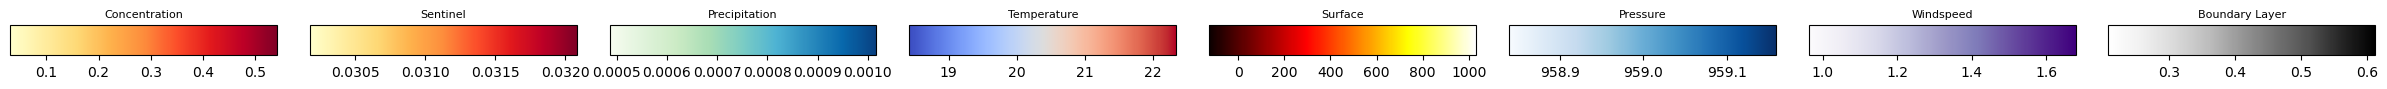

In [21]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd

# Cleaning
summary = summary.loc[:, ~summary.columns.duplicated()]
summary.columns.name = None
summary = summary.round(10)

# Column grouping by keyword
cols_concentration = [c for c in summary.columns if "Concentration" in c]
cols_sentinel      = [c for c in summary.columns if "Sentinel" in c]
cols_precipitacion = [c for c in summary.columns if "Precipitation" in c]
cols_temperature   = [c for c in summary.columns if "Temperature" in c]
cols_pressure      = [c for c in summary.columns if "Pressure" in c]
cols_wind          = [c for c in summary.columns if "Windspeed" in c]
cols_blh           = [c for c in summary.columns if "Boundary Layer" in c]
cols_surface       = [c for c in summary.columns if "Surface" in c]

# Ensure numeric
for cols in [cols_concentration, cols_sentinel, cols_precipitacion, cols_temperature,
             cols_pressure, cols_wind, cols_blh, cols_surface]:
    for c in cols:
        summary[c] = pd.to_numeric(summary[c], errors="coerce")

def get_col_scale(series, buffer=0.05):
    vals = pd.to_numeric(series, errors="coerce").dropna()
    if len(vals) == 0:
        return (None, None)
    vmin, vmax = vals.min(), vals.max()
    diff = vmax - vmin
    return (vmin - diff*buffer, vmax + diff*buffer)

# Dynamic scales computation for all columns
scales = {}
for c in summary.select_dtypes(include=["float", "int"]).columns:
    vmin, vmax = get_col_scale(summary[c])
    if vmin is not None and vmax is not None:
        scales[c] = (vmin, vmax)

# Palettes
color_map_rules = {
    "Concentration": "YlOrRd",
    "Sentinel": "YlOrRd",
    "Precipitation": "GnBu",
    "Temperature": "coolwarm",
    "Surface": "hot",
    "Pressure": "Blues",
    "Windspeed": "Purples",
    "Boundary Layer": "Greys"
}

# Styling
styled_summary = summary.style

for col in summary.columns:
    cmap = None
    for key, cmap_name in color_map_rules.items():
        if key in col:
            cmap = cmap_name
            break
    if cmap and col in scales:
        vmin, vmax = scales[col]
        styled_summary = styled_summary.background_gradient(
            subset=[col], cmap=cmap, vmin=vmin, vmax=vmax
        )

styled_summary = (
    styled_summary
    .set_properties(**{
        "text-align": "center",
        "font-family": "Segoe UI, sans-serif",
        "font-size": "10pt",
        "border": "1px solid #ddd",
        "padding": "3px"
    })
    .format(precision=6)
)

display(styled_summary)

# Legends
legend_data = {}
for key, cmap_name in color_map_rules.items():
    cols = [c for c in summary.columns if key in c and c in scales]
    if cols:
        vmins = [scales[c][0] for c in cols if scales[c][0] is not None]
        vmaxs = [scales[c][1] for c in cols if scales[c][1] is not None]
        if vmins and vmaxs:
            legend_data[key] = (cmap_name, min(vmins), max(vmaxs))

fig, axes = plt.subplots(1, len(legend_data), figsize=(3*len(legend_data), 1))
if len(legend_data) == 1:
    axes = [axes]

for ax, (label, (cmap_name, vmin, vmax)) in zip(axes, legend_data.items()):
    if vmin is not None and vmax is not None and vmin != vmax:
        norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
        cmap = mpl.cm.get_cmap(cmap_name)
        mpl.colorbar.ColorbarBase(ax, cmap=cmap, norm=norm, orientation="horizontal")
    ax.set_title(label, fontsize=8)

plt.tight_layout()
plt.show()

## Visualization of data WITHOUT NaN

 Cleaning summary:
   • NaN rows removed: 0
   • Rows removed for negative concentrations: 1 (0 total negative values)
   • Final dataset size: 2 rows × 23 columns



,Date,Province,ID Sensor,Latitude,Longitude,Pollutant,"Previous Mean Concentration (CO, µg/m³)","Current Mean Concentration (CO, µg/m³)",Sentinel 5P Concentration CO (mol/m²),Previous Temperature (°C),Current Temperature (°C),Previous Pressure (hPa),Current Pressure (hPa),Previous Total Precipitation (mm),Current Total Precipitation (mm),Previous Windspeed (m/s),Current Windspeed (m/s),Previous Surface Solar Radiation (kJ/m²),Current Surface Solar Radiation (kJ/m²),Previous Surface Thermal Radiation (kJ/m²),Current Surface Thermal Radiation (kJ/m²),Previous Boundary Layer Height [km],Current Boundary Layer Height [km]
0,2025-06-01,CO,5798,45.815042,9.066979,Monossido di Carbonio,0.475000,0.366667,0.030262,18.421670,22.346140,958.838568,959.158715,0.001017,0.000485,0.962771,1.678445,260.729147,1030.259353,-71.370969,-125.917002,0.207055,0.613000
2,2025-06-03,CO,5798,45.815042,9.066979,Monossido di Carbonio,0.414286,0.533333,0.031995,18.421670,22.346140,958.838568,959.158715,0.001017,0.000485,0.962771,1.678445,260.729147,1030.259353,-71.370969,-125.917002,0.207055,0.613000


C:\Users\Administrador\AppData\Local\Temp\ipykernel_18920\2940035130.py:123: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mpl.cm.get_cmap(cmap_name)


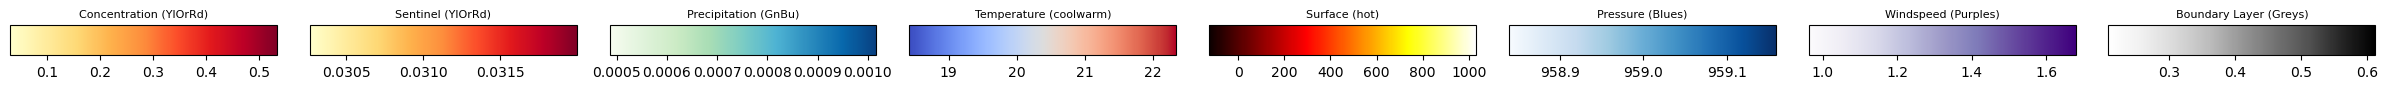

In [22]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np

# Cleaning
summary = summary.loc[:, ~summary.columns.duplicated()]
summary.columns.name = None
summary = summary.replace(["None", "none", "NaN", "nan", ""], np.nan)
summary = summary.round(10)

# Convert columns to numeric when possible
for col in summary.columns:
    try:
        summary[col] = pd.to_numeric(summary[col])
    except (ValueError, TypeError):
        pass

# Count and drop NaN rows
nan_before = len(summary)
summary = summary.dropna(how="all").reset_index(drop=True)
nan_removed = nan_before - len(summary)

# Dynamic Selection by keyword 
cols_concentration = [c for c in summary.columns if "Concentration" in c]
cols_sentinel      = [c for c in summary.columns if "Sentinel" in c]
cols_precipitacion = [c for c in summary.columns if "Precipitation" in c]
cols_temperature   = [c for c in summary.columns if "Temperature" in c]
cols_pressure      = [c for c in summary.columns if "Pressure" in c]
cols_wind          = [c for c in summary.columns if "Windspeed" in c]
cols_blh           = [c for c in summary.columns if "Boundary Layer" in c]
cols_surface       = [c for c in summary.columns if "Surface" in c]

# Negative values removal for concentration columns only
neg_before = len(summary)
if cols_concentration:
    neg_count = (summary[cols_concentration] < 0).sum().sum()
    summary = summary[(summary[cols_concentration] >= 0).all(axis=1)]
    neg_removed = neg_before - len(summary)
else:
    neg_count = 0
    neg_removed = 0

#  Cleaning summary printout 
print(f" Cleaning summary:")
print(f"   • NaN rows removed: {nan_removed}")
print(f"   • Rows removed for negative concentrations: {neg_removed} ({int(neg_count)} total negative values)")
print(f"   • Final dataset size: {len(summary)} rows × {len(summary.columns)} columns\n")

# Function for dynamic min/max per column
def get_col_scale(series, buffer=0.05):
    vals = pd.to_numeric(series, errors="coerce").dropna()
    if len(vals) == 0:
        return (None, None)
    vmin, vmax = vals.min(), vals.max()
    diff = vmax - vmin
    return (vmin - diff * buffer, vmax + diff * buffer)

# Compute dynamic scales per column
scales = {}
for c in summary.select_dtypes(include=["float", "int"]).columns:
    vmin, vmax = get_col_scale(summary[c])
    if vmin is not None and vmax is not None:
        scales[c] = (vmin, vmax)

# Palettes
color_map_rules = {
    "Concentration": "YlOrRd",
    "Sentinel": "YlOrRd",
    "Precipitation": "GnBu",
    "Temperature": "coolwarm",
    "Surface": "hot",
    "Pressure": "Blues",
    "Windspeed": "Purples",
    "Boundary Layer": "Greys"
}

# Dynamic styling
styled_summary = summary.style
for col in summary.columns:
    cmap = None
    for key, cmap_name in color_map_rules.items():
        if key in col:
            cmap = cmap_name
            break
    if cmap and col in scales:
        vmin, vmax = scales[col]
        styled_summary = styled_summary.background_gradient(
            subset=[col], cmap=cmap, vmin=vmin, vmax=vmax
        )

# Global style
styled_summary = (
    styled_summary
    .set_properties(**{
        "text-align": "center",
        "font-family": "Segoe UI, sans-serif",
        "font-size": "10pt",
        "border": "1px solid #ddd",
        "padding": "3px"
    })
    .format(precision=6)
)

display(styled_summary)

# Legend
color_maps = {}
for key, cmap_name in color_map_rules.items():
    cols = [c for c in summary.columns if key in c]
    if cols:
        vmin = summary[cols].min().min()
        vmax = summary[cols].max().max()
        color_maps[f"{key} ({cmap_name})"] = (cmap_name, vmin, vmax)

fig, axes = plt.subplots(1, len(color_maps), figsize=(3 * len(color_maps), 1))
if len(color_maps) == 1:
    axes = [axes]

for ax, (label, (cmap_name, vmin, vmax)) in zip(axes, color_maps.items()):
    if pd.notna(vmin) and pd.notna(vmax) and vmin != vmax:
        norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
        cmap = mpl.cm.get_cmap(cmap_name)
        mpl.colorbar.ColorbarBase(ax, cmap=cmap, norm=norm, orientation="horizontal")
    ax.set_title(label, fontsize=8)

plt.tight_layout()
plt.show()


In [ ]:
start_str = pd.to_datetime(cfg["start_date"]).strftime("%Y%m%d")
end_str = pd.to_datetime(cfg["end_date"]).strftime("%Y%m%d")

# Folder creation
output_dir = f"results/ARPA_ERA_S5P-{start_str}_to_{end_str}"
os.makedirs(output_dir, exist_ok=True)

# CSV file output
output_path = os.path.join(output_dir, "summary_clean.csv")


summary.to_csv(output_path, index=False)

print(f"\nFile saved in:\n{output_path}\n")
